# Government Documents RAG System with LangGraph

This notebook demonstrates how to build a RAG (Retrieval-Augmented Generation) system for government documents using LangGraph and Claude.

## 1. Setup and Installation

In [1]:
import os
import getpass
import fitz  # PyMuPDF
from typing import Annotated, List, Dict, Any, TypedDict, Optional
from typing_extensions import TypedDict
import sys

# LangChain imports
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader, TextLoader
from langchain_community.vectorstores import Chroma
from langchain_chroma import Chroma as LCChroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_anthropic import ChatAnthropic
from langchain.schema import Document

# LangGraph imports
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

## 2. Set API Keys

In [2]:
def set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

set_env("ANTHROPIC_API_KEY")

## 3. Document Processing

We'll create a class to handle loading and processing documents from a directory.

In [3]:
import os
import re
import fitz  # PyMuPDF
from typing import List, Optional, Dict, Any
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain.schema import Document

class DocumentProcessor:
    def __init__(self, docs_dir: str, chunk_size: int = 1000, chunk_overlap: int = 200):
        self.docs_dir = docs_dir
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=self.chunk_size,
            chunk_overlap=self.chunk_overlap,
            length_function=len,
        )
        
    def extract_text_with_layout(self, pdf_path: str) -> List[Dict[str, Any]]:
        """
        Extract text from PDF while preserving layout information.
        Uses PyMuPDF (fitz) to get better results with complex layouts.
        """
        doc = fitz.open(pdf_path)
        extracted_data = []
        
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            
            # Get page dimensions to determine orientation
            width, height = page.rect.width, page.rect.height
            orientation = "landscape" if width > height else "portrait"
            
            # Extract text blocks with their bounding boxes
            blocks = page.get_text("blocks")
            
            # Sort blocks - for dual column papers, sort by x coordinate first then y
            if self._is_likely_multi_column(blocks):
                # Use x coordinate to identify columns, then sort by y within columns
                col_threshold = width / 2  # Simple assumption of a two-column layout
                left_col = [b for b in blocks if b[0] < col_threshold]
                right_col = [b for b in blocks if b[0] >= col_threshold]
                
                # Sort each column by y-coordinate
                left_col.sort(key=lambda b: b[1])
                right_col.sort(key=lambda b: b[1])
                
                # Process left column, then right column
                sorted_blocks = left_col + right_col
            else:
                # Sort blocks by y-coordinate for standard top-to-bottom reading
                sorted_blocks = sorted(blocks, key=lambda b: b[1])
            
            for block in sorted_blocks:
                # Each block is (x0, y0, x1, y1, text, block_type, block_no)
                block_text = block[4]
                if block_text.strip():  # Skip empty blocks
                    extracted_data.append({
                        "page": page_num + 1,
                        "text": block_text,
                        "orientation": orientation,
                        "bbox": block[:4],  # Bounding box coordinates
                    })
        
        return extracted_data
    
    def _is_likely_multi_column(self, blocks, threshold=0.3):
        """
        Detect if a page likely has a multi-column layout.
        """
        if not blocks:
            return False
            
        # Extract x-coordinates where blocks start
        x_starts = [b[0] for b in blocks]
        
        # Get page width from the maximum x-coordinate of any block
        page_width = max(b[2] for b in blocks)
        
        # Count blocks that start in left vs right half of page
        left_half = sum(1 for x in x_starts if x < page_width/2)
        right_half = sum(1 for x in x_starts if x >= page_width/2)
        
        # If there's a significant number of blocks in both halves, likely multi-column
        total_blocks = len(blocks)
        return (left_half / total_blocks > threshold and 
                right_half / total_blocks > threshold)
    
    def load_documents(self) -> List[Document]:
        """Load documents from the specified directory with enhanced PDF processing"""
        # Create directory if it doesn't exist
        if not os.path.exists(self.docs_dir):
            os.makedirs(self.docs_dir)
            print(f"Created directory: {self.docs_dir}")
            return []
        
        # Process all PDF files with enhanced layout handling
        pdf_docs = []
        pdf_files = [f for f in os.listdir(self.docs_dir) 
                     if f.lower().endswith('.pdf')]
        
        for filename in pdf_files:
            filepath = os.path.join(self.docs_dir, filename)
            try:
                print(f"Processing PDF: {filename}")
                extracted_data = self.extract_text_with_layout(filepath)
                
                # Group content by page
                pages = {}
                for item in extracted_data:
                    page_num = item["page"]
                    if page_num not in pages:
                        pages[page_num] = []
                    pages[page_num].append(item)
                
                # Create a document for each page
                for page_num, page_items in pages.items():
                    page_text = "\n".join([item["text"] for item in page_items])
                    
                    # Clean up text - replace excessive newlines and spaces
                    page_text = re.sub(r'\n{3,}', '\n\n', page_text)
                    page_text = re.sub(r' {2,}', ' ', page_text)
                    
                    # Create document with metadata
                    doc = Document(
                        page_content=page_text,
                        metadata={
                            "source": filepath,
                            "page": page_num,
                            "file_name": filename,
                        }
                    )
                    pdf_docs.append(doc)
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
        
        # Load text files with standard TextLoader
        text_docs = []
        text_files = [f for f in os.listdir(self.docs_dir) 
                     if f.lower().endswith('.txt')]
        
        if text_files:
            text_loader = DirectoryLoader(self.docs_dir, glob="**/*.txt", loader_cls=TextLoader)
            text_docs = text_loader.load()
        
        # Combine all documents
        all_docs = pdf_docs + text_docs
        
        print(f"Loaded {len(all_docs)} documents")
        return all_docs
    
    def process_documents(self, documents: List[Document]) -> List[Document]:
        """Split documents into chunks for vectorization"""
        if not documents:
            print("No documents to process")
            return []
            
        chunked_documents = self.text_splitter.split_documents(documents)
        print(f"Split into {len(chunked_documents)} chunks")
        return chunked_documents

## 4. Vector Store Setup

Now let's create a vector store for document embeddings.

In [7]:
class VectorStore:
    def __init__(self, persist_directory: str = "./chroma_db"):
        self.persist_directory = persist_directory
        self.embeddings = HuggingFaceEmbeddings(
            model_name="all-MiniLM-L6-v2",
            model_kwargs={'device': 'cpu'},
        )
        self.vectordb = None
        
    def create_or_load_db(self, documents: Optional[List[Document]] = None) -> Chroma:
        """Create a new vector store or load existing one"""
        # Create directory if it doesn't exist
        if not os.path.exists(self.persist_directory):
            os.makedirs(self.persist_directory)
            
        if documents and len(documents) > 0:
            # Create a new vector store
            print(f"Creating new vector database with {len(documents)} documents")
            self.vectordb = LCChroma.from_documents(
                documents=documents,
                embedding=self.embeddings,
                persist_directory=self.persist_directory,
            )
            # The persist() call is no longer needed - removal fixes the error
            # LCChroma automatically persists when persist_directory is provided
            print(f"Vector database created and persisted to {self.persist_directory}")
        else:
            # Load existing vector store if it exists
            try:
                print(f"Loading existing vector database from {self.persist_directory}")
                self.vectordb = LCChroma(
                    persist_directory=self.persist_directory,
                    embedding_function=self.embeddings,
                )
                print(f"Successfully loaded vector database with {self.vectordb._collection.count()} documents")
            except Exception as e:
                print(f"Error loading existing database: {e}")
                print("Creating an empty vector database instead")
                self.vectordb = LCChroma(
                    embedding_function=self.embeddings,
                    persist_directory=self.persist_directory,
                )
        
        return self.vectordb
    
    def get_retriever(self, k: int = 4):
        """Get a retriever from the vector store"""
        if self.vectordb is None:
            raise ValueError("VectorDB not initialized. Call create_or_load_db first.")
        
        return self.vectordb.as_retriever(
            search_type="similarity",
            search_kwargs={"k": k}
        )

## 5. Build the RAG System

In [8]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    retrieved_documents: Optional[List[Document]]

class GovernmentDocsRAG:
    def __init__(self, model_name: str = "claude-3-5-sonnet-20240620"):
        self.memory = MemorySaver()
        self.llm = ChatAnthropic(model=model_name)
        
        # Define system prompt for the chatbot
        self.system_prompt = """You are a helpful assistant specialized in answering questions about government documents. 
When responding:
1. Base your answers on the retrieved documents
2. If the documents don't contain the answer, say you don't know
3. Always cite your sources by referencing the document name and section
4. Be concise but thorough in your responses
5. Format your response in a readable way

Current retrieved documents for this query: {documents}
"""
        
        # Initialize the graph
        self.graph_builder = StateGraph(State)
        
    def build_graph(self, retriever):
        """Build the LangGraph flow"""
        # Define the retriever node
        def retrieve_documents(state: State) -> Dict[str, Any]:
            """Retrieve relevant documents based on the user query"""
            # Get the latest user message
            user_message = state["messages"][-1].content
            
            # Retrieve documents
            retrieved_docs = retriever.get_relevant_documents(user_message)
            
            # Format documents for better readability
            return {"retrieved_documents": retrieved_docs}
        
        # Define the RAG node
        def generate_response(state: State) -> Dict[str, Any]:
            """Generate a response using the LLM with retrieved documents"""
            # Get documents
            docs = state.get("retrieved_documents", [])
            
            # Format documents for the prompt
            doc_strings = []
            for i, doc in enumerate(docs):
                doc_strings.append(f"Document {i+1}:\nContent: {doc.page_content}\nSource: {doc.metadata.get('source', 'Unknown')}")
            
            formatted_docs = "\n\n".join(doc_strings)
            
            # Create prompt with documents
            messages = state["messages"].copy()
            
            # Add system prompt with documents
            system_prompt_with_docs = self.system_prompt.format(documents=formatted_docs)
            
            # Create augmented LLM
            llm_with_docs = self.llm.bind(system=system_prompt_with_docs)
            
            # Generate response
            return {"messages": [llm_with_docs.invoke(messages)]}
        
        # Add nodes to the graph
        self.graph_builder.add_node("retrieve", retrieve_documents)
        self.graph_builder.add_node("rag_response", generate_response)
        
        # Add edges
        self.graph_builder.add_edge(START, "retrieve")
        self.graph_builder.add_edge("retrieve", "rag_response")
        self.graph_builder.add_edge("rag_response", END)
        
        # Compile the graph
        self.graph = self.graph_builder.compile(checkpointer=self.memory)
        
        return self.graph
    
    def chat(self, user_input: str, thread_id: str = "default"):
        """Chat with the RAG system"""
        config = {"configurable": {"thread_id": thread_id}}
        
        result = self.graph.invoke(
            {"messages": [{"role": "user", "content": user_input}]},
            config,
        )
        
        # Return the AI's response
        return result["messages"][-1].content
    
    def get_conversation_history(self, thread_id: str = "default"):
        """Get the full conversation history"""
        config = {"configurable": {"thread_id": thread_id}}
        state = self.graph.get_state(config)
        
        # Return all messages if available
        if state and "messages" in state.values:
            return state.values["messages"]
        return []

## 6. Set Up the RAG Pipeline

In [9]:
# Process the sample documents
doc_processor = DocumentProcessor(docs_dir="./documents")
raw_docs = doc_processor.load_documents()
processed_docs = doc_processor.process_documents(raw_docs)

Processing PDF: H.R.1968 - Full-Year Continuing Appropriations and Extensions Act, 03-14-2025.pdf
Loaded 102 documents
Split into 201 chunks


In [10]:
# Set up the vector store
vector_store = VectorStore(persist_directory="./docs_db")
vector_db = vector_store.create_or_load_db(documents=processed_docs)
retriever = vector_store.get_retriever(k=3)

/tmp/ipykernel_3519/1818294722.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  self.embeddings = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Creating new vector database with 201 documents
Vector database created and persisted to ./docs_db


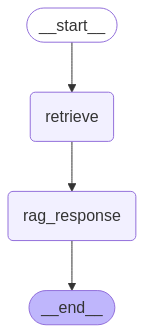

In [11]:
# Set up the RAG system
rag_system = GovernmentDocsRAG()
rag_system.build_graph(retriever)

## 7. Example Interactions

Let's interact with our RAG system by asking questions about the government documents.

In [16]:
# Example 1: Ask about education policy
question1 = "How many titles are there in division B, and what is division B about?"
print(f"Question: {question1}")
response1 = rag_system.chat(question1, thread_id="demo_session")
print(f"Response: {response1}")

Question: How many titles are there in division B, and what is division B about?
Response: Based on the information provided in the retrieved documents, I can answer part of your question:

Division B of the bill is titled "HEALTH" and contains at least one title:

TITLE I—PUBLIC HEALTH EXTENDERS

This information comes from Document 3, which shows the table of contents for the bill.

However, I cannot definitively state how many total titles are in Division B, as the documents provided do not show a complete list of titles for this division. The information given only shows Title I, but there may be additional titles that are not visible in the excerpts provided.

To summarize, Division B is about Health, and it contains at least one title focused on Public Health Extenders. For a complete count of titles in Division B, we would need to consult the full text of the bill.


In [15]:
# Example 2: Ask about healthcare reform
question2 = "How does HR1968 affect funding for low-income programs?"
print(f"Question: {question2}")
response2 = rag_system.chat(question2, thread_id="demo_session")
print(f"Response: {response2}")

Question: How does HR1968 affect funding for low-income programs?
Response: Based on the limited information provided in the retrieved documents, I cannot give a comprehensive answer about how HR 1968 affects funding for all low-income programs. The documents do not contain specific details about funding changes for most low-income programs.

However, I can provide one relevant piece of information from the documents:

The bill appears to extend and increase funding for certain programs that assist low-income individuals, particularly in accessing healthcare information and resources. Specifically:

1. State Health Insurance Assistance Programs: Funding is increased from $22,500,000 to $30,000,000 and extended to September 30, 2025 (previously March 31, 2025).

2. Area Agencies on Aging: Funding is increased from $22,500,000 to $30,000,000 and extended to September 30, 2025.

3. Aging and Disability Resource Centers: Funding is increased from $8,500,000 to $10,000,000 and extended to S

In [ ]:
# Example 3: Ask a follow-up question to test memory
question3 = "When will these funding mechanisms be implemented?"
print(f"Question: {question3}")
response3 = rag_system.chat(question3, thread_id="demo_session")
print(f"Response: {response3}")

In [ ]:
# Example 4: Ask about environmental regulations
question4 = "What are the new carbon emission targets for power plants?"
print(f"Question: {question4}")
response4 = rag_system.chat(question4, thread_id="demo_session")
print(f"Response: {response4}")

In [ ]:
# Example 5: Ask about something not in the documents
question5 = "What is the government's policy on international trade?"
print(f"Question: {question5}")
response5 = rag_system.chat(question5, thread_id="demo_session")
print(f"Response: {response5}")

## 8. Get Conversation History

Let's retrieve the full conversation history to verify that our memory is working.

In [14]:
# Get conversation history
history = rag_system.get_conversation_history(thread_id="demo_session")
for i, message in enumerate(history):
    if message.role == "user":
        print(f"User: {message.content}")
    else:
        print(f"Assistant: {message.content[:100]}...")
    print("-" * 50)

AttributeError: 'HumanMessage' object has no attribute 'role'

## 9. Working with Your Own Government Documents

To use this system with your own government documents:

1. Create a directory for your documents
2. Add your PDF and/or text files to this directory
3. Update the document processor to point to your directory
4. Run the processing and vector store creation steps
5. Initialize the RAG system with your retriever

Here's a template for how you would do this:

In [ ]:
# Example: Set up with your own documents
'''
# Define your documents directory
my_docs_dir = "./my_government_docs"

# Process your documents
doc_processor = DocumentProcessor(docs_dir=my_docs_dir)
raw_docs = doc_processor.load_documents()
processed_docs = doc_processor.process_documents(raw_docs)

# Set up vector store with your documents
vector_store = VectorStore(persist_directory="./my_government_docs_db")
vector_db = vector_store.create_or_load_db(documents=processed_docs)
retriever = vector_store.get_retriever(k=4)

# Set up RAG system
rag_system = GovernmentDocsRAG()
rag_system.build_graph(retriever)

# Start interacting
response = rag_system.chat("What is the government's policy on X?", thread_id="my_session")
print(response)
'''